In [68]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping

In [69]:
path = './malimg_dataset/'

In [70]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 1 classes.


In [71]:
familias.class_indices

{'malimg_paper_dataset_imgs': 0}

In [72]:
imgs, labels = next(familias)

In [73]:
imgs.shape

(9339, 64, 64, 3)

In [74]:
labels.shape

(9339, 1)

In [75]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [76]:
!pip show keras
!pip show tensorflow

Name: keras
Version: 2.13.1
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: 
Required-by: tensorflow-intel
Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: tensorflow-intel
Required-by: 


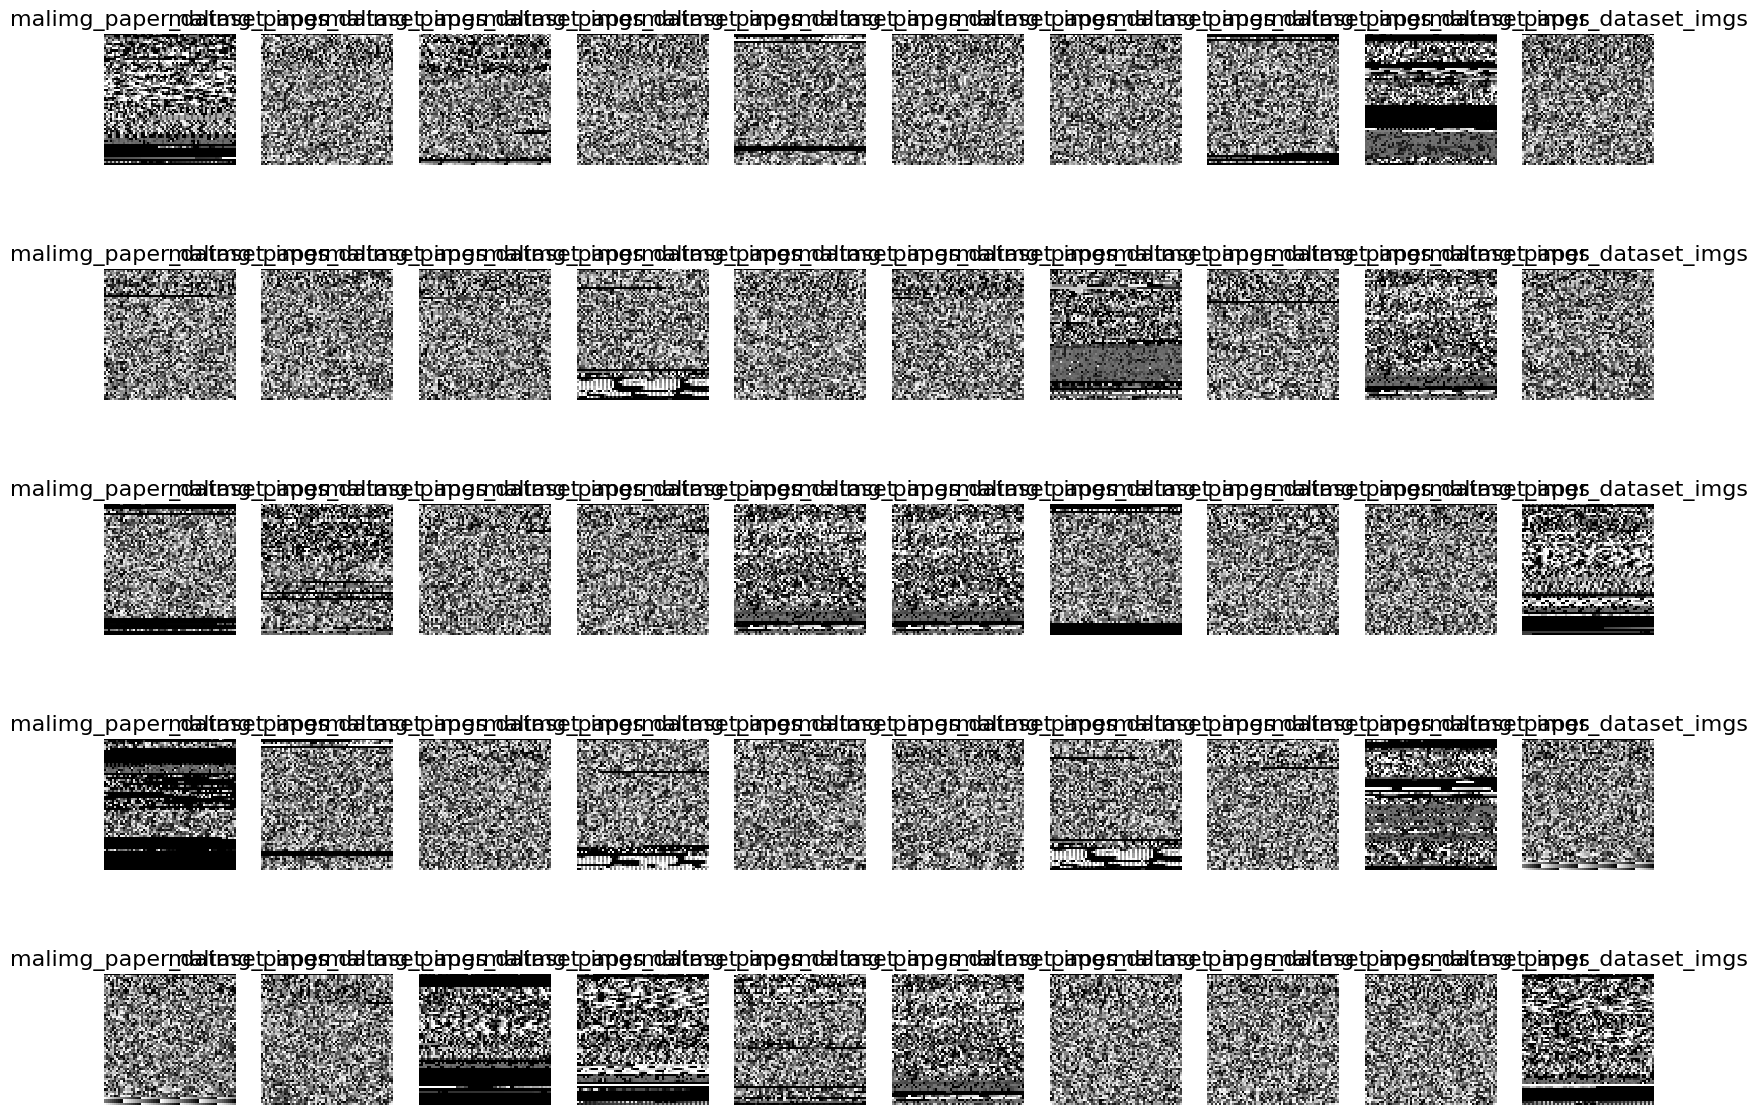

In [77]:

plots(imgs, titles = labels)

### Primera parte

Pre preprocesamiento adicional

Conteo de observaciones

In [78]:
# Path al directorio con las imágenes
path = './malimg_dataset/'

# Creando un generador de datos con escalamiento de las imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargando imágenes desde el directorio
generator = datagen.flow_from_directory(
    directory=path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Obteniendo las etiquetas de las clases del generador
class_indices = generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Contando el número de imágenes por clase
for _, labels in generator:
    for label in labels:
        class_name = list(class_indices.keys())[np.argmax(label)]
        class_counts[class_name] += 1
    if generator.batch_index == 0:
        break

print("Conteo de observaciones por familia de malware:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Found 9339 images belonging to 1 classes.
Conteo de observaciones por familia de malware:
malimg_paper_dataset_imgs: 9339


Dividiendo la data en 70% train y 30% test

In [79]:
all_images = []
all_labels = []

# Cargando todas las imágenes y etiquetas
for _ in range(generator.samples // generator.batch_size + 1):
    imgs, labels = next(generator)
    all_images.append(imgs)
    all_labels.append(labels)

# Concatenando todas las imágenes y etiquetas en un solo array
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Asegurándose de no tener más datos de los necesarios
all_images = all_images[:generator.samples]
all_labels = all_labels[:generator.samples]

In [80]:
# Dividiendo los datos en un conjunto de entrenamiento y otro de prueba
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)

print(X_train, X_test)

[[[[0.8941177  0.8941177  0.8941177 ]
   [0.00392157 0.00392157 0.00392157]
   [0.27058825 0.27058825 0.27058825]
   ...
   [0.         0.         0.        ]
   [0.07450981 0.07450981 0.07450981]
   [0.00784314 0.00784314 0.00784314]]

  [[0.27450982 0.27450982 0.27450982]
   [0.14117648 0.14117648 0.14117648]
   [0.         0.         0.        ]
   ...
   [0.2901961  0.2901961  0.2901961 ]
   [0.05882353 0.05882353 0.05882353]
   [0.01568628 0.01568628 0.01568628]]

  [[0.5176471  0.5176471  0.5176471 ]
   [0.92549026 0.92549026 0.92549026]
   [0.35686275 0.35686275 0.35686275]
   ...
   [0.3137255  0.3137255  0.3137255 ]
   [0.76470596 0.76470596 0.76470596]
   [0.01568628 0.01568628 0.01568628]]

  ...

  [[0.7137255  0.7137255  0.7137255 ]
   [0.8000001  0.8000001  0.8000001 ]
   [0.         0.         0.        ]
   ...
   [0.41176474 0.41176474 0.41176474]
   [0.43921572 0.43921572 0.43921572]
   [0.47450984 0.47450984 0.47450984]]

  [[0.42352945 0.42352945 0.42352945]
   [0.1

In [81]:
print("Shape of X_train:", X_train.shape)

Shape of X_train: (6537, 64, 64, 3)


In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=3, activation="relu", input_shape=(64, 64, 3)),  
        MaxPooling2D(pool_size=2),
        BatchNormalization(),  # Batch Normalization después de la primera capa de convolución
        Conv2D(64, kernel_size=3, activation="relu"),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),  # Batch Normalization después de la segunda capa de convolución
        Flatten(),
        Dense(128, activation="relu", 
              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),  
        Dropout(0.9),  # Ajustando la tasa de dropout
        Dense(10, activation="softmax")
    ])

    # Compilando el modelo con regularización L1 y L2
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [83]:
from keras.utils import to_categorical

# Convertiendo las etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Creando el modelo
model = create_model()

model.fit(X_train, y_train, epochs=5, batch_size=256)

model.save("model.h5")

Train on 6537 samples
Epoch 1/5
6537/6537 [==============================] - 16s 2ms/sample - loss: 17.6237 - accuracy: 0.7698
Epoch 2/5
6537/6537 [==============================] - 15s 2ms/sample - loss: 11.8033 - accuracy: 0.9547
Epoch 3/5
6537/6537 [==============================] - 15s 2ms/sample - loss: 6.5882 - accuracy: 0.9735
Epoch 4/5
6537/6537 [==============================] - 15s 2ms/sample - loss: 3.2474 - accuracy: 0.9829
Epoch 5/5
6537/6537 [==============================] - 15s 2ms/sample - loss: 1.6694 - accuracy: 0.9859


c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Segunda parte

In [84]:
!pip install adversarial-robustness-toolbox

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Cargando el modelo

In [85]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier

# Desactivando la ejecución ansiosa
tf.compat.v1.disable_eager_execution()

# Cargando el modelo
model = load_model('model.h5')

# Envolviendo el modelo con ART
classifier = KerasClassifier(model=model)

Ataque de evasión

In [86]:
from art.attacks.evasion import FastGradientMethod
from sklearn.metrics import accuracy_score

# Configurando el ataque FGSM
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.001)  # eps controla la magnitud del ataque

# Generando ejemplos de ataque
x_test_adv = attack_fgsm.generate(x=X_test)

# Evaluando el modelo en datos de prueba normales para comparar
predictions_normal = classifier.predict(X_test)

# Asegurar que las etiquetas tengan el formato correcto
y_test = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
predictions_normal = np.argmax(predictions_normal, axis=1) if len(predictions_normal.shape) > 1 else predictions_normal

# Calcular accuracy utilizando accuracy_score
accuracy_normal = accuracy_score(y_test, predictions_normal)
print(f"Accuracy en datos normales: {accuracy_normal * 100:.2f}%")

# Evaluando el modelo con los datos de ataque
predictions = classifier.predict(x_test_adv)

# Asegurar que las etiquetas tengan el formato correcto
predictions = np.argmax(predictions, axis=1) if len(predictions.shape) > 1 else predictions

# Calcular accuracy utilizando accuracy_score
accuracy_fgsm = accuracy_score(y_test, predictions)
print(f"Accuracy en datos de ataque FGSM: {accuracy_fgsm * 100:.2f}%")

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy en datos normales: 20.99%
Accuracy en datos de ataque FGSM: 20.74%


**Explicación del ataque de evasión:**

El código que se tiene en la celda pertenece a un ataque adversario usando el método de "Fast Gradient Sign Method (FGSM) por medio de la librería ART (Adversarial Robustness Toolbox) en Python. Primero, importo la librería FGSM y configuro el modelo "classifier" a atacar y la magnitud del ataque (en este caso un eps de 0.1). Luego, se generan imágenes adversarias y se asignan a la variable "x_test_adv" modificando así las imágenes de prueba de la variable "X_test" con el objetivo de engañar al modelo.

El modelo se evalúa primero en las imágenes originales de prueba para obtener una línea base de precisión (o sea el "accuracy_normal"), enseñando así como se desempeña el modelo en condiciones normales. Finalmente, se evalúa la precisión del modelo con las imágenes adversarias para ver como afecta el ataque FGSM a su rendimiento ayudando a entender la robustez del modelo ante ataques adversarios. Este proceso es altamente importante para la seguridad en modelos de aprendizaje automático, permitiendo así identificar y mejorar su resistencia frente a manipulaciones malintencionadas.

**Defensa adversarial**

In [87]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = tf.sign(data_grad)
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image

def adversarial_training(model, X_train, y_train, epsilon=0.00000001, epochs=5):
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            tape.watch(X_train)
            predictions = model(X_train, training=True)
            loss = loss_fn(y_train, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        with tf.GradientTape() as tape:
            tape.watch(X_train)
            predictions = model(X_train, training=True)
            loss = loss_fn(y_train, predictions)
        input_gradients = tape.gradient(loss, X_train)

        X_train_adv = fgsm_attack(X_train, epsilon, input_gradients)

        with tf.GradientTape() as tape:
            predictions_adv = model(X_train_adv, training=True)
            loss_adv = loss_fn(y_train, predictions_adv)
        gradients_adv = tape.gradient(loss_adv, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients_adv, model.trainable_variables))

        accuracy_metric.update_state(y_train, model(X_train, training=True))
        acc = accuracy_metric.result()

        print(f'Epoch {epoch + 1}, Loss:', tf.keras.backend.eval(loss), ', Accuracy:', tf.keras.backend.eval(acc))

        accuracy_metric.reset_states()

# Asegurando de que X_train y y_train sean tensores
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

adversarial_training(model, X_train, y_train)

Epoch 1, Loss: 0.07384261 , Accuracy: 0.0
Epoch 2, Loss: 0.07161434 , Accuracy: 0.0
Epoch 3, Loss: 0.07144716 , Accuracy: 0.0
Epoch 4, Loss: 0.07629257 , Accuracy: 0.0
Epoch 5, Loss: 0.07266963 , Accuracy: 0.0


**Explicación de la defensa adversarial:** 

En el anterior código, se implementa un entrenamiento adversarial para un modelo de red neuronal usando TensorFlow. Asimismo, se usa un optimizador Adam y una función de pérdida de entropía cruzada categórica para entrenar el modelo. En cada época del entrenamiento se calcula el gradiente de la pérdida respecto a las variables entrenables, se generan perturbaciones basadas en estos gradientes (multiplicando el signdo del gradiente por un factor epsilon), y se aplican directamente a los pesos del modelo para aumentar su robustez. Esta defensa busca hacer que el modelo sea resistente a ejemplos adversarios, que son ligeras variaciones de los datos diseñadas para confundir al modelo atacante, mejorando así la precisión del modelo en los datos normales y en las condiciones adversas.

**Ataque de extracción**

In [88]:
# Importación de librerías necesarias
import numpy as np
import tensorflow as tf
from art.estimators.classification import KerasClassifier
from art.attacks.extraction import CopycatCNN
from sklearn.metrics import accuracy_score

# Aplicando ruido gaussiano a las predicciones
def add_gaussian_noise(predictions, sigma=0.1):
    noise = np.random.normal(0, sigma, predictions.shape)
    return np.clip(predictions + noise, 0, 1)

# Cargando el modelo preentrenado (víctima)
model_victim = tf.keras.models.load_model('model.h5')

# Envolviendo el modelo en un clasificador ART
classifier_victim = KerasClassifier(model=model_victim, clip_values=(0, 1))

# Envolviendo y defendiendo el modelo con ruido gaussiano
def predict_with_noise(classifier, X):
    predictions = classifier.predict(X)
    return add_gaussian_noise(predictions)

thieved_model = create_model()

# Envolviendo el thieved model con un clasificador de ART
thieved_classifier = KerasClassifier(model=thieved_model, clip_values=(0, 1))

X_data = np.random.rand(100, 64, 64, 3)  # 100 imágenes aleatorias como ejemplo

# Configurando el ataque Copycat CNN
attack = CopycatCNN(classifier=classifier_victim, batch_size_fit=32, batch_size_query=32, nb_epochs=10, nb_stolen=100)

# Ejecutando el ataque para extraer un nuevo modelo
thieved_classifier = attack.extract(x=X_data, thieved_classifier=thieved_classifier)

# Realizando las predicciones
predictions = predict_with_noise(classifier_victim, X_test)

if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

# Verificando y ajustando las predicciones si es necesario
if len(predictions.shape) > 1:
    predictions = np.argmax(predictions, axis=1)

# Calculando el accuracy del modelo víctima
predictions_original = classifier_victim.predict(X_test)
if len(predictions_original.shape) > 1:
    predictions_original = np.argmax(predictions_original, axis=1)

accuracy_original = np.mean(predictions_original == y_test)
print(f"Accuracy of the original model: {accuracy_original * 100:.2f}%")

# Calculando el accuracy del modelo atacante
accuracy_thieved = np.mean(predictions == y_test)
print(f"Accuracy of the thieved model: {accuracy_thieved * 100:.2f}%")

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy of the original model: 20.99%
Accuracy of the thieved model: 18.49%


**Explicación del ataque de extracción:**

El código que se tiene para el ataque de extracción utiliza la técnica de Copycat CNN para robar la funcionalidad de un modelo preentrenado usando así la librería ART en Python. En un principio se importan las librerías necesarisa y se carga el modelo preentrenado, designado así como el modelo víctima. El modelo cargado se envuelve en un clasificador ART, configurando así sus valores de entrada entre 0 y 1. Luego, se crea un nuevo modelo, denominado thieved modelo, que también se envuelve en un clasificador ART. SE preparan 100 imágenes aleatorias de tamaño 64x64 en 3 canales (que en este caso es el color completo) para utilizarlas en el ataque. El ataque Copycat CNN se configura con parámetros como tamaño de lote y número de épocas, y luego se ejecuta usando el clasificador de la víctima y las imágenes aleatorias para entrenar el modelo thieved a imitar el comportamiento del modelo original.

Posteriormente, se evalúan ambolos modelos (víctima y thieved) en un conjunto de prueba "X_test", ajustando las predicciones y los etiquetados para calcular la precsión de clasificación. Finalmente, se calcula y se compara la precisión del modelo original y del modelo thieved, enseñando así que tan efectivo fue el modelo thieved para imitar la funcionalidad del modelo víctima. Lo anterior es importante para el contexto de seguridad para entender y reducir los riesgos de ataques que buscan clonar la funcionalidad de modelos sensibles.

**Explicación de la defensa con ruido gaussiano:**

La defensa consiste en agregar ruido gaussiano a las predicciones del modelo víctima antes de que estas sean usadas para entrenar otro modelo (en este caso llamado "thieved model"). El ruido se geenra al sumar cada predicción un valor aleaotrio normalmente distribuido con media cero y desviación estándar definida por sigma y luego se asegura que los valores resultantes estén dentro del rango entre 0 y 1 usando así una función de numpy llamada "np.clip". Este proceso de inyección de ruido tiene como objetivo distorcionar las señales que el atacante puede usar para aprender y replicar el comportamiento del modelo víctima, reduciendo así la efectividad de extracción. Al final, se evalúa la precisión del modelo original y del modelo extraído para verificar cuánto ha afectado el ruido a la capacidad del atacante para replicar el modelo víctima correctamente.